<a href="https://colab.research.google.com/github/busterbn/deep-learning/blob/master/Week4%20Convolutional/4.2%20CNN%20CIFAR-10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN on CIFAR-10

In this notebook you need to put what you have learned into practice, and create your own convolutional classifier for the CIFAR-10 dataset.

The images in CIFAR-10 are RGB images (3 channels) with size 32x32 (so they have size 3x32x32). There are 10 different classes. See examples below.

![cifar10](https://github.com/DeepLearningDTU/02456-deep-learning-with-PyTorch/blob/master/static_files/cifar10.png?raw=1)


## Preliminaries

In [14]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from sklearn import metrics

sns.set_style("whitegrid")

def accuracy(target, pred):
    return metrics.accuracy_score(target.detach().cpu().numpy(), pred.detach().cpu().numpy())

def compute_confusion_matrix(target, pred, normalize=None):
    return metrics.confusion_matrix(
        target.detach().cpu().numpy(),
        pred.detach().cpu().numpy(),
        normalize=normalize
    )

def show_image(img):
    img = img.detach().cpu()
    img = img / 2 + 0.5   # unnormalize
    with sns.axes_style("white"):
        plt.figure(figsize=(8, 8))
        plt.imshow(img.permute((1, 2, 0)).numpy())
        plt.axis('off')
        plt.show()

In [15]:
# The output of torchvision datasets are PIL images in the range [0, 1].
# We transform them to PyTorch tensors and rescale them to be in the range [-1, 1].
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # subtract 0.5 and divide by 0.5
    ]
)

batch_size = 64  # both for training and testing

# Load datasets
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)

# Map from class index to class name.
classes = {index: name for name, index in train_set.class_to_idx.items()}

In [16]:
print("Training data")
print("Number of points:", len(train_set))
x, y = next(iter(train_loader))
print("Batch dimension (B x C x H x W):", x.shape)
print(f"Number of distinct labels: {len(set(train_set.targets))} (unique labels: {set(train_set.targets)})")

print("\nTest data")
print("Number of points:", len(test_set))
x, y = next(iter(test_loader))
print("Batch dimension (B x C x H x W):", x.shape)
print(f"Number of distinct labels: {len(set(test_set.targets))} (unique labels: {set(test_set.targets)})")

n_classes = len(set(test_set.targets))

Training data
Number of points: 50000
Batch dimension (B x C x H x W): torch.Size([64, 3, 32, 32])
Number of distinct labels: 10 (unique labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9})

Test data
Number of points: 10000
Batch dimension (B x C x H x W): torch.Size([64, 3, 32, 32])
Number of distinct labels: 10 (unique labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9})


### Show example images

Run multiple times to see different examples.

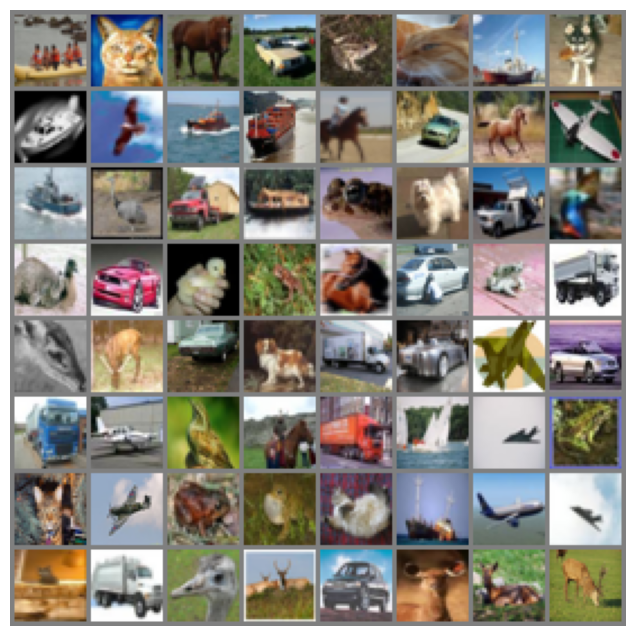

In [17]:
# Get random training images and show them.
images, labels = next(iter(train_loader))
show_image(torchvision.utils.make_grid(images))

## Define a convolutional neural network


**Assignment 1:** Define a convolutional neural network.
You may use the code from previous notebooks.
We suggest that you start with a small network, and make sure that everything is working.
Once you can train successfully, come back and improve the architecture.

In [18]:
class PrintSize(nn.Module):
    """Utility module to print current shape of a Tensor in Sequential, only at the first pass."""

    first = True

    def forward(self, x):
        if self.first:
            print(f"Size: {x.size()}")
            self.first = False
        return x

in_channels = 3

num_filters_l1 = 32
num_filters_l2 = num_filters_l1 * 2
num_filters_l3 = num_filters_l2 * 2


height = 32
width = 32

# Filter stuff
kernel_size = 5
padding = 2

class Model(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes

        # Calculate the correct number of features after conv and flatten
        # After conv: num_filters * height * width = 1 * 32 * 32 = 1024

        self.net = nn.Sequential(
            # PrintSize(),
            nn.Conv2d(in_channels, out_channels=32, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Dropout2d(0.1),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Dropout2d(0.15),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Dropout2d(0.2),

            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),

            nn.Linear(32768, 512),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(128, 10),
        )

    def forward(self, x):
        return self.net(x)


model = Model(n_classes)
device = torch.device('cuda')  # use cuda or cpu
model.to(device)
print(model)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Test the forward pass with dummy data
out = model(torch.randn(100, 3, 32, 32, device=device))
print("Output shape:", out.size())
print(f"Output logits:\n{out.detach().cpu().numpy()}")
print(f"Output probabilities:\n{out.softmax(1).detach().cpu().numpy()}")


Model(
  (net): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): Dropout2d(p=0.1, inplace=False)
    (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): Dropout2d(p=0.15, inplace=False)
    (6): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (7): ReLU()
    (8): Dropout2d(p=0.2, inplace=False)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Flatten(start_dim=1, end_dim=-1)
    (11): Linear(in_features=32768, out_features=512, bias=True)
    (12): ReLU()
    (13): Dropout(p=0.5, inplace=False)
    (14): Linear(in_features=512, out_features=128, bias=True)
    (15): ReLU()
    (16): Dropout(p=0.5, inplace=False)
    (17): Linear(in_features=128, out_features=10, bias=True)
  )
)
Output shape: torch.Size([100, 10])
Output logits:
[[ 8.27991366e-02 -7.38413185e-02  2.28858143e-02  6.34453371e-02
   7.21017830e-03 -5.

## Define a loss function and optimizer

**Assignment 2:** Define the loss function and optimizer.
You might need to experiment a bit with the learning rate.

In [19]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)


## Train the network

**Assignment 3:** Finish the training loop below.
Start by using a small number of epochs (e.g. 2).
Even with a low number of epochs you should be able to see results that are better than chance.
When everything is working increase the number of epochs to find out how good your network really is.

In [20]:
# Test the forward pass with dummy data
out = model(torch.randn(2, 3, 32, 32, device=device))
print("Output shape:", out.size())
print(f"Output logits:\n{out.detach().cpu().numpy()}")
print(f"Output probabilities:\n{out.softmax(1).detach().cpu().numpy()}")

Output shape: torch.Size([2, 10])
Output logits:
[[-0.00465205 -0.00930558  0.08159342 -0.02182169  0.01484368  0.0477399
   0.07110059  0.01313103  0.08773764 -0.08307759]
 [ 0.0865894  -0.0591995   0.0353336   0.06614087  0.02250985 -0.04544793
   0.05790122  0.00185452  0.06162697 -0.07793646]]
Output probabilities:
[[0.09746698 0.09701446 0.1062462  0.09580779 0.09938581 0.1027096
  0.10513721 0.09921574 0.10690101 0.09011512]
 [0.10726747 0.09271558 0.10190792 0.10509629 0.10060942 0.09399938
  0.10423389 0.09855261 0.10462295 0.09099454]]


In [21]:
num_epochs = 10
validation_every_steps = 500

step = 0
model.train()

train_accuracies = []
valid_accuracies = []

best_val_acc = 0
patience = 10
patience_counter = 0

for epoch in range(num_epochs):
    train_accuracies_batches = []

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        # Forward pass, compute gradients, perform one training step.
        output = model(inputs)
        loss = loss_fn(output, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Increment step counter
        step += 1

        # Compute accuracy.
        predictions = output.max(1)[1]
        train_accuracies_batches.append(accuracy(targets, predictions))

        if step % validation_every_steps == 0:
            # Append average training accuracy to list.
            train_accuracies.append(np.mean(train_accuracies_batches))
            train_accuracies_batches = []

            # Compute accuracies on validation set.
            valid_accuracies_batches = []
            with torch.no_grad():
                model.eval()
                for inputs, targets in test_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    output = model(inputs)
                    loss = loss_fn(output, targets)

                    predictions = output.max(1)[1]
                    # Multiply by len(x) because the final batch of DataLoader may be smaller (drop_last=False).
                    valid_accuracies_batches.append(accuracy(targets, predictions) * len(inputs))

                model.train()

            # Append average validation accuracy to list.
            val_acc = np.sum(valid_accuracies_batches) / len(test_set)
            valid_accuracies.append(val_acc)

            print(f"Step {step:<5}   training accuracy: {train_accuracies[-1]}")
            print(f"             test accuracy: {val_acc}")

            # Early stopping check
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                patience_counter = 0
                # Gem model
                torch.save(model.state_dict(), 'best_model.pth')
                print(f"             → New best model saved! (accuracy: {best_val_acc:.4f})")
            else:
                patience_counter += 1

            if patience_counter >= patience:
                print(f"\nEarly stopping triggered! Best validation accuracy: {best_val_acc:.4f}")
                break

    # Check for early stopping at epoch level
    if patience_counter >= patience:
        break

print("Finished training.")
print(f"Best validation accuracy: {best_val_acc:.4f}")

Step 500     training accuracy: 0.32925
             test accuracy: 0.4669
             → New best model saved! (accuracy: 0.4669)
Step 1000    training accuracy: 0.48423165137614677
             test accuracy: 0.5595
             → New best model saved! (accuracy: 0.5595)
Step 1500    training accuracy: 0.5145625
             test accuracy: 0.5952
             → New best model saved! (accuracy: 0.5952)
Step 2000    training accuracy: 0.5647219036697247
             test accuracy: 0.6305
             → New best model saved! (accuracy: 0.6305)
Step 2500    training accuracy: 0.6126217532467533
             test accuracy: 0.629
Step 3000    training accuracy: 0.6165625
             test accuracy: 0.6565
             → New best model saved! (accuracy: 0.6565)
Step 3500    training accuracy: 0.6486895161290323
             test accuracy: 0.6747
             → New best model saved! (accuracy: 0.6747)
Step 4000    training accuracy: 0.6805555555555556
             test accuracy: 0.6799
     

## Test the network

Now we show a batch of test images and generate a table below with the true and predicted class for each of these images.

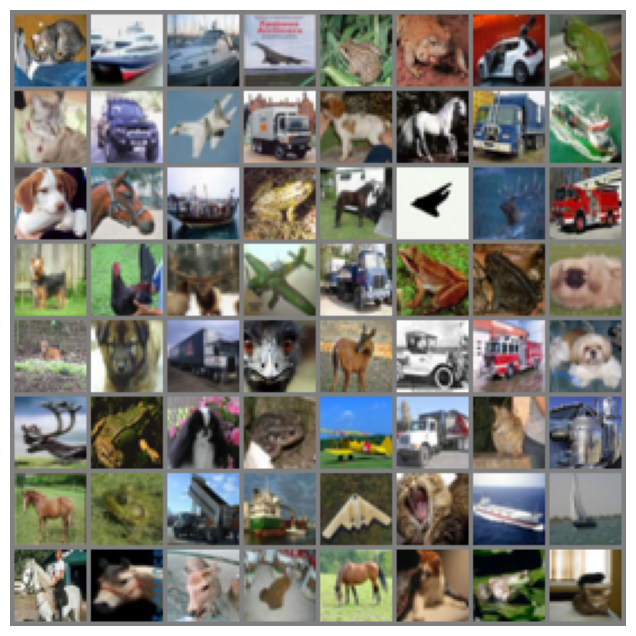

    TRUE        PREDICTED
-----------------------------
     cat           dog     
    ship          ship     
    ship       automobile  
  airplane        ship     
    frog          frog     
    frog          frog     
 automobile        dog     
    frog          deer     
     cat           cat     
 automobile    automobile  
  airplane      airplane   
    truck         truck    
     dog          frog     
    horse         horse    
    truck         truck    
    ship          ship     
     dog           dog     
    horse         frog     
    ship          truck    
    frog          frog     
    horse         horse    
  airplane      airplane   
    deer        airplane   
    truck         truck    
     dog          deer     
    bird          bird     
    deer          bird     
  airplane      airplane   
    truck         truck    
    frog          frog     
    frog          frog     
     dog           dog     
    deer          deer     
     dog           d

In [22]:
inputs, targets = next(iter(test_loader))
inputs, targets = inputs.to(device), targets.to(device)
show_image(make_grid(inputs))
plt.show()

outputs = model(inputs)
_, predicted = torch.max(outputs.data, 1)

print("    TRUE        PREDICTED")
print("-----------------------------")
for target, pred in zip(targets, predicted):
    print(f"{classes[target.item()]:^13} {classes[pred.item()]:^13}")


We now evaluate the network as above, but on the entire test set.

In [23]:
# Evaluate test set
confusion_matrix = np.zeros((n_classes, n_classes))
with torch.no_grad():
    model.eval()
    test_accuracies = []
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        output = model(inputs)
        loss = loss_fn(output, targets)

        predictions = output.max(1)[1]

        # Multiply by len(inputs) because the final batch of DataLoader may be smaller (drop_last=True).
        test_accuracies.append(accuracy(targets, predictions) * len(inputs))

        confusion_matrix += compute_confusion_matrix(targets, predictions)

    test_accuracy = np.sum(test_accuracies) / len(test_set)

    model.train()


Here we report the **average test accuracy** (number of correct predictions divided by test set size).

In [24]:
print(f"Test accuracy: {test_accuracy:.3f}")

Test accuracy: 0.707


Here we look a bit more in depth into the performance of the classifier, using the **confusion matrix**. The entry at the i-th row and j-th column indicates the number of samples with true label being the i-th class and predicted label being the j-th class.

We normalize the rows: given all examples of a specific class (row), we can observe here how they are classified by our model. Ideally, we would like the entries on the diagonals to be 1, and everything else 0. This would mean that all examples from that class are classified correctly.

The classes that are harder to classify for our model have lower numbers on the diagonal. We can then see exactly *how* they are misclassified by looking at the rest of the row.


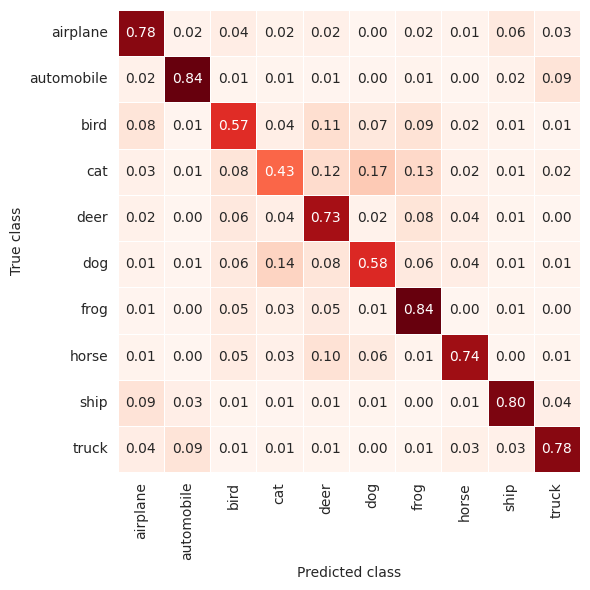

In [25]:
def normalize(matrix, axis):
    axis = {'true': 1, 'pred': 0}[axis]
    return matrix / matrix.sum(axis=axis, keepdims=True)

x_labels = [classes[i] for i in classes]
y_labels = x_labels
plt.figure(figsize=(6, 6))
sns.heatmap(
    ax=plt.gca(),
    data=normalize(confusion_matrix, 'true'),
    annot=True,
    linewidths=0.5,
    cmap="Reds",
    cbar=False,
    fmt=".2f",
    xticklabels=x_labels,
    yticklabels=y_labels,
)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.ylabel("True class")
plt.xlabel("Predicted class")
plt.tight_layout()
plt.show()

Here we focus on the diagonal and plot the numbers in a bar plot. This gives us a clearer picture of the accuracy of the model for different classes.

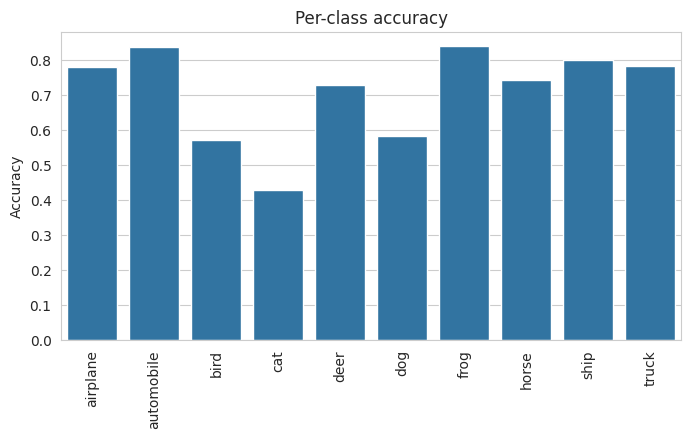

In [26]:
with sns.axes_style('whitegrid'):
    plt.figure(figsize=(8, 4))
    sns.barplot(x=x_labels, y=np.diag(normalize(confusion_matrix, 'true')))
    plt.xticks(rotation=90)
    plt.title("Per-class accuracy")
    plt.ylabel("Accuracy")
    plt.show()

**Assignment 4:**
1. Go back and improve performance of the network. By using enough convolutional layers with enough channels (and by training for long enough), you should easily be able to get a test accuracy above 60%, but see how much further you can get it! Can you reach 70%?

2. Briefly describe what you did and any experiments you did along the way as well as what results you obtained.
Did anything surprise you during the exercise?
What were the changes that seemed to improve performance the most?

3. Write down key lessons/insights you got during this exercise.

**Answer:**

1. Jeg fik den op på 70,7 %
2. Det hjalp meget at tilføje flere outs fra conv layers.
3. Jeg oplevede at modellen kom op tæt på 70% omkring step 2500 og så faldt den igen, men test accuracy fortsat med at stige. Så jeg tilføjede dropout og weight decay for at undgå overfitting som hjalp meget. Det fik den op på lige over 70% test accuracy.

# Training on GPU

**Optional Assignment:**
If you have a GPU, we suggest that you try training your model on GPU. For this, you need to move the model to GPU after defining it, which will recursively go over all modules and convert their parameters and buffers to CUDA tensors. You also need to transfer both the inputs and targets to GPU at each training step, before performing the forward pass.

The code for this is already in place: notice the `.to(device)` statements. The only thing left to do is change the definition of `device` from `'cpu'` to `'cuda'`.

If you don't have a GPU, you can do this on [Google Colab](https://research.google.com/colaboratory/).

Use the code below to check if any GPU is avaiable in your current setup. This should print the models of all available GPUs.


In [27]:
# Check if we have GPUs available
print("Available CUDA devices:", [torch.cuda.get_device_name(i) for i in range(torch.cuda.device_count())])

Available CUDA devices: ['Tesla T4']


You may not notice any significant speed-up from using a GPU. This is probably because your network is really small. Try increasing the width of your network (number of channels in the convolutional layers) and see if you observe any speed-up on GPU compared to CPU.